# MNIST Classification

Classification of hand written digits 0--9 using a Multi Layer Perceptron

- Input: $28 \times 28$ grayscale images, scaled to $[0, 1)$   
- Output: Class label
- Hidden layers $tanh$, RELU or sigmoid activations

Demonstration on the classical MNIST dataset

In [7]:
from matplotlib.pylab import plt
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

step = 2
train_offset = 0
features = mnist['data'][train_offset:-1:step].copy()/255
target = mnist['target'][train_offset:-1:step].copy()

test_offset = 1
features_test = mnist['data'][test_offset:-1:step].copy()/255
target_test = mnist['target'][test_offset:-1:step].copy()


assert(train_offset != test_offset)

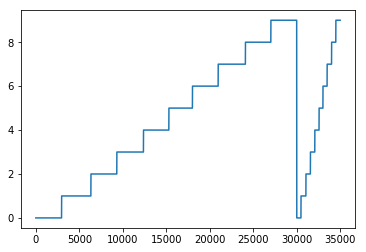

In [8]:
plt.plot(target)
plt.show()

In [39]:
# %load "DrawNN.py"
#Code from https://gist.github.com/craffel/2d727968c3aaebd10359

import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes, bias=0, draw_edges=True):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
        - bias : Boolean
            Draw an extra bias node at each layer
        - draw_edges : Boolean
            If false, omit edge connections
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes)+bias)
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        bias_node = (bias if n<len(layer_sizes)-1 else 0)
        for m in range(layer_size+bias_node ):
            node_color = 'w' if m<layer_size else 'b'
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/8.,
                                color=node_color, ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    if draw_edges:
        for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
            for m in range(layer_size_a+bias):
                for o in range(layer_size_b):
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], 
                                      c='k')
                    ax.add_artist(line)

In [40]:
import torch
import torch.autograd
from torch.autograd import Variable

# The sizes of layers from input to output
#sizes = [3,3,10,20,3,4]
sizes = [28*28, 32, 10]

# Generate the network
g = torch.tanh
sm = torch.nn.Softmax(dim=0)
identity = lambda x: x

D = len(sizes)
Weight = []
Bias = []
Func = []
for i in range(D-1):
    # For layer i, Weights are a S_{i+1} \times S_{i} matrix
    W = Variable(torch.randn(sizes[i+1],sizes[i]).double(), requires_grad=True)
    # For layer i, Biases are a S_{i+1} \times 1 matrix (a vector)
    b = Variable(torch.randn(sizes[i+1],1).double(), requires_grad=True)
    Weight.append(W)
    Bias.append(b)
    Func.append(g)
    
#Reset the final layer to sigmoid mapping
#Func[-1] = torch.sigmoid
Func[-1] = sm


# Define the exact functional form
# x: A S_0 \times B matrix where each column is a training example with S_0 features
def mlp_fun(x, Weight, Bias, Func):
    f = Variable(x, requires_grad=False)
    NumOfLayers = len(Weight)
    for i in range(NumOfLayers):
        #print(f)
        f = Func[i](torch.matmul(Weight[i], f) + Bias[i])
    return f


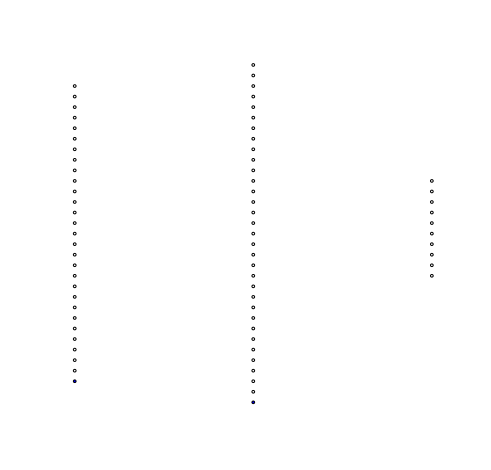

In [43]:
%matplotlib inline
sizes_plot = sizes.copy()
sizes_plot[0] = 28
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, sizes_plot, bias=1, draw_edges=False)

tensor([[0.0003],
        [0.0004],
        [0.0000],
        [0.0001],
        [0.0000],
        [0.9884],
        [0.0028],
        [0.0038],
        [0.0042],
        [0.0001]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)


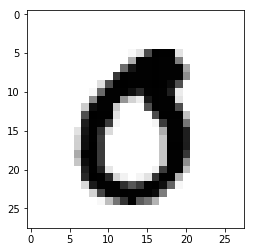

tensor([[4.2999e-05],
        [1.0063e-06],
        [9.1493e-07],
        [1.1657e-06],
        [3.3607e-09],
        [8.7990e-03],
        [1.6255e-04],
        [9.8851e-01],
        [5.8956e-06],
        [2.4735e-03]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)


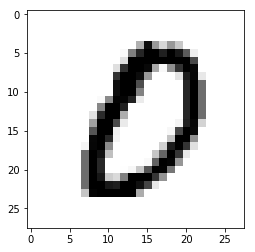

tensor([[0.0000],
        [0.0121],
        [0.4607],
        [0.0028],
        [0.0000],
        [0.0014],
        [0.0003],
        [0.0105],
        [0.3489],
        [0.1632]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)


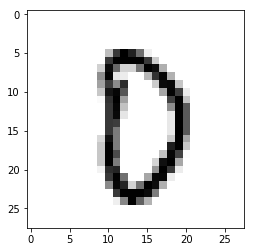

In [36]:
IDX = [100,200, 400]

for idx in IDX: 
    x = features[idx]

    #x[x>0] = 1
    plt.imshow(x.reshape(28,28), cmap='gray_r')
    print(mlp_fun(torch.DoubleTensor(x.reshape(28*28,1)), Weight, Bias, Func))
    plt.show()


Binary Cross Entropy Loss

$y$: target

$$
y \log(\theta) + (1-y) \log(1-\theta)
$$

In [23]:
loss_fn = torch.nn.BCELoss()

E = Variable(torch.DoubleTensor([0]))
for idx in [100,101,102]:
    x = features[idx]
    f = mlp_fun(torch.DoubleTensor(x.reshape(28*28,1)), Weight, Bias, Func)
    y = Variable(torch.DoubleTensor(target[idx].reshape([1,1])))
    E = E + loss_fn(f, y)

print(E/3)

tensor([[-0.9973],
        [ 1.0000],
        [ 0.9999],
        [-0.9998],
        [ 1.0000],
        [ 1.0000],
        [-1.0000],
        [-1.0000],
        [ 1.0000],
        [ 1.0000],
        [-0.2362],
        [-0.9881],
        [-1.0000],
        [-1.0000],
        [ 0.9817],
        [-1.0000],
        [-1.0000],
        [ 1.0000],
        [ 0.9984],
        [ 1.0000],
        [ 1.0000],
        [ 0.7553],
        [ 0.9999],
        [-1.0000],
        [ 1.0000],
        [ 1.0000],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [ 1.0000],
        [ 0.9491],
        [-0.9999],
        [ 1.0000],
        [-1.0000],
        [-0.9999],
        [-1.0000],
        [ 1.0000],
        [ 0.9967],
        [ 0.9999],
        [-0.9993],
        [-1.0000],
        [-1.0000],
        [-1.0000],
        [-0.4429],
        [-1.0000],
        [ 1.0000],
        [-0.9904],
        [-1.0000],
        [-0.9991],
        [-1.0000],
        [-0.9999],
        [-1.0000],
        [ 0.

/Users/onurasiliskender/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([10, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


ValueError: Target and input must have the same number of elements. target nelement (1) != input nelement (10)

In [150]:
# Batch Mode

loss_fn = torch.nn.BCELoss(size_average=False)

idx = range(0,100)
x = features[idx]
f = mlp_fun(torch.DoubleTensor(x.T), Weight, Bias, Func)
y = Variable(torch.DoubleTensor(target[idx].reshape([1, len(idx)])))
loss_fn(f, y)


Variable containing:
 11.8843
[torch.DoubleTensor of size 1]

# Training



In [38]:
import numpy as np

# Cross Entropy
Error = torch.nn.CrossEntropyLoss(size_average=True, reduce=True)

# Number of examples in the Training set 
N = len(target)

eta = 1
MAX_ITER = 50000
BatchSize = min(100, N)
EE = []
for epoch in range(MAX_ITER):
    idx = np.random.choice(N, size=BatchSize, replace=False)
    x = features[idx]
    #idx = [epoch%N]
    f = mlp_fun(torch.DoubleTensor(x.T), Weight, Bias, Func)
    y = Variable(torch.LongTensor(target[idx].reshape([len(idx)])), requires_grad=False)
    # Measure the error
    E = Error(f.transpose(0,1), y)
    EE.append(E.data.numpy())
    
    # Compute the derivative of the error with respect to Weights and Biases
    E.backward() 
    
    # Take the step and reset weights
    for i in range(D-1):
        Weight[i].data.add_(-eta*Weight[i].grad.data)
        Bias[i].data.add_(-eta*Bias[i].grad.data)
        Weight[i].grad.zero_()
        Bias[i].grad.zero_()
    
    if epoch % 1000 == 0:
        print(epoch, E.data[0])
        
plt.plot(EE)
plt.show()

/Users/onurasiliskender/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/Users/onurasiliskender/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0 tensor(1.7196, dtype=torch.float64)
1000 tensor(1.5817, dtype=torch.float64)
2000 tensor(1.6160, dtype=torch.float64)
3000 tensor(1.5791, dtype=torch.float64)


KeyboardInterrupt: 

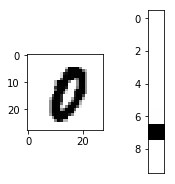

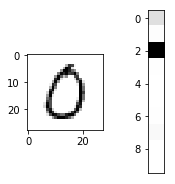

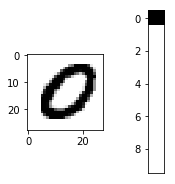

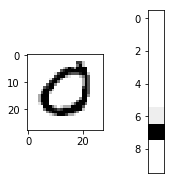

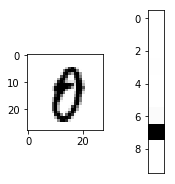

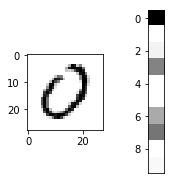

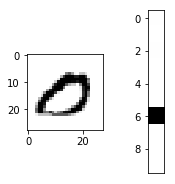

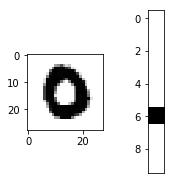

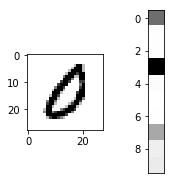

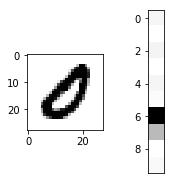

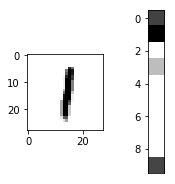

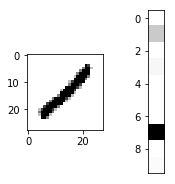

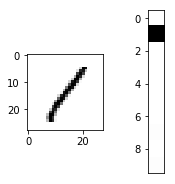

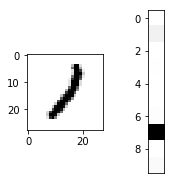

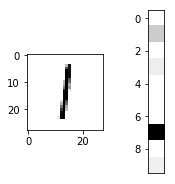

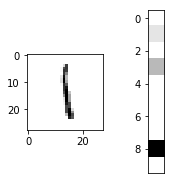

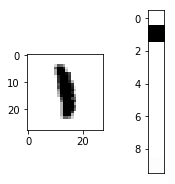

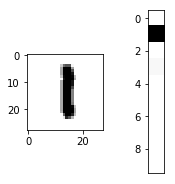

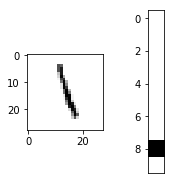

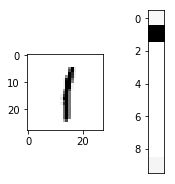

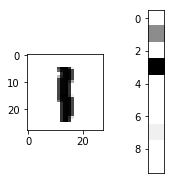

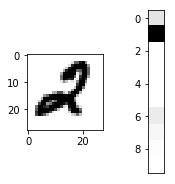

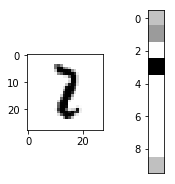

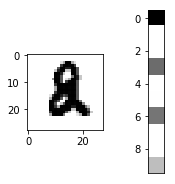

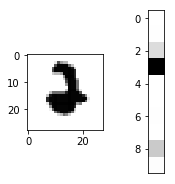

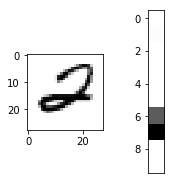

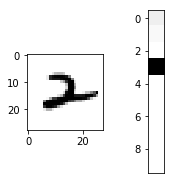

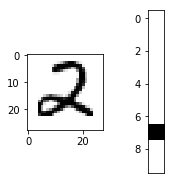

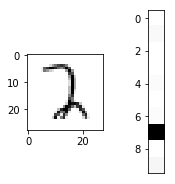

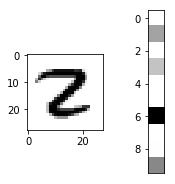

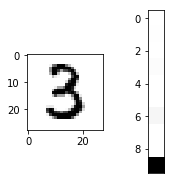

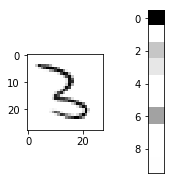

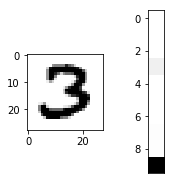

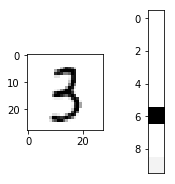

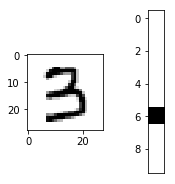

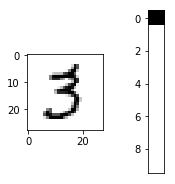

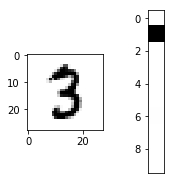

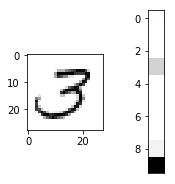

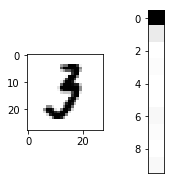

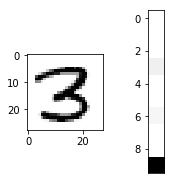

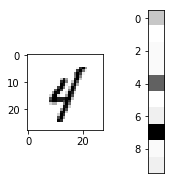

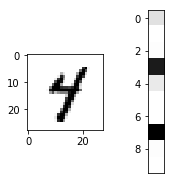

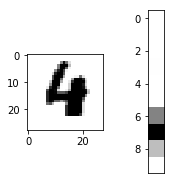

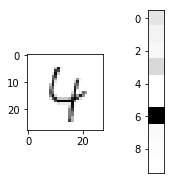

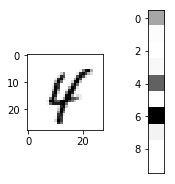

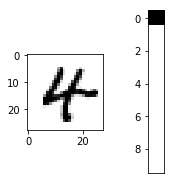

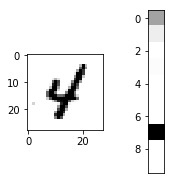

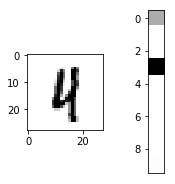

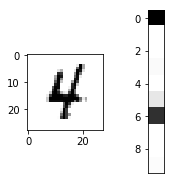

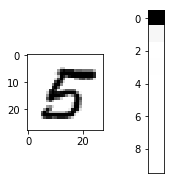

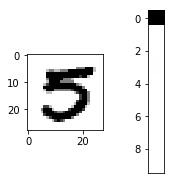

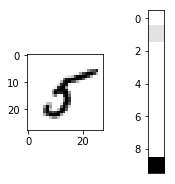

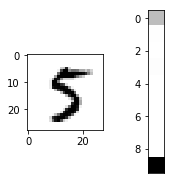

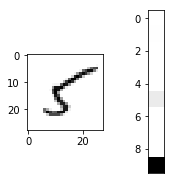

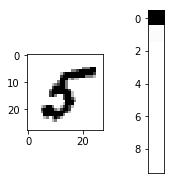

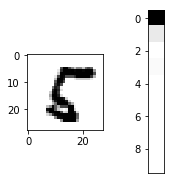

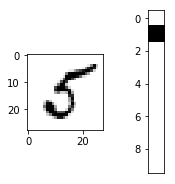

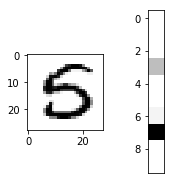

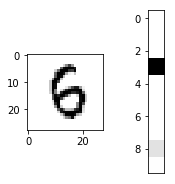

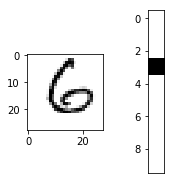

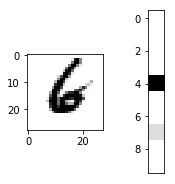

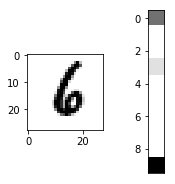

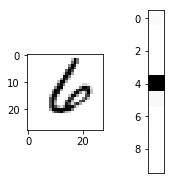

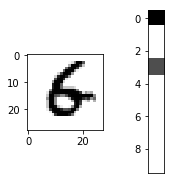

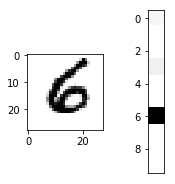

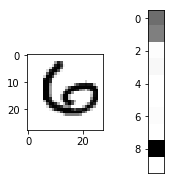

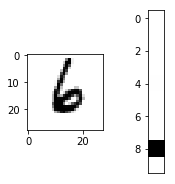

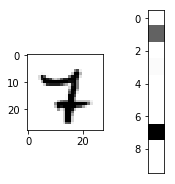

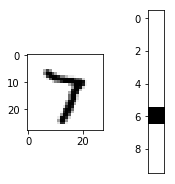

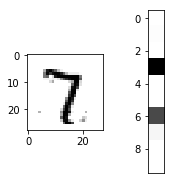

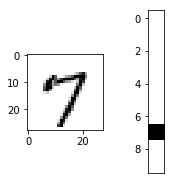

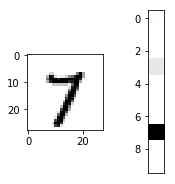

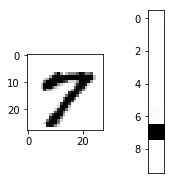

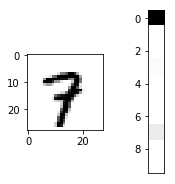

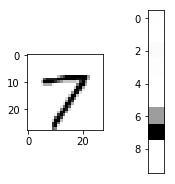

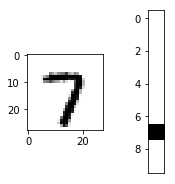

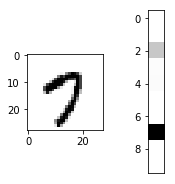

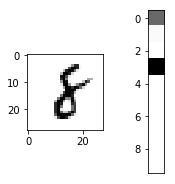

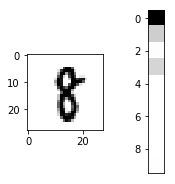

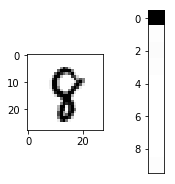

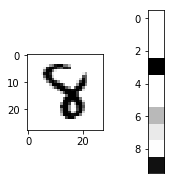

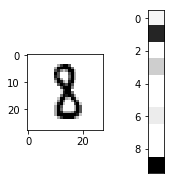

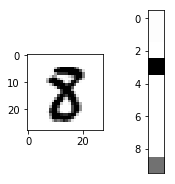

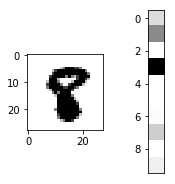

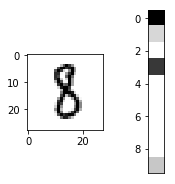

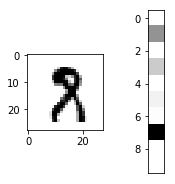

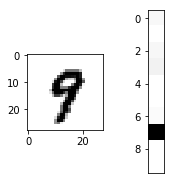

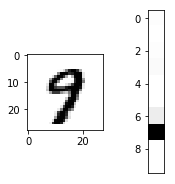

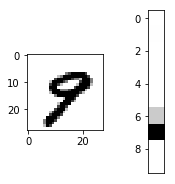

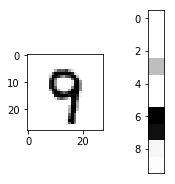

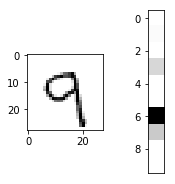

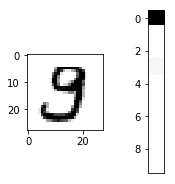

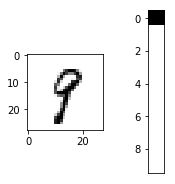

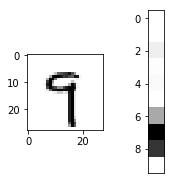

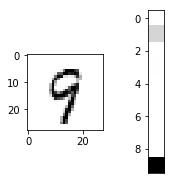

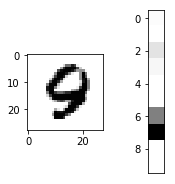

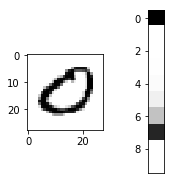

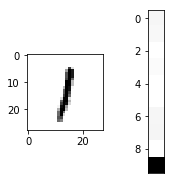

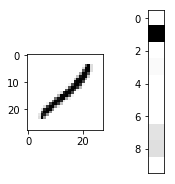

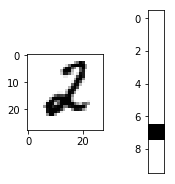

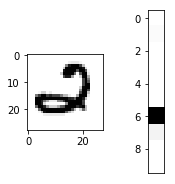

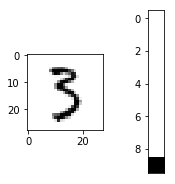

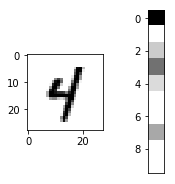

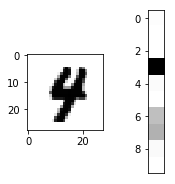

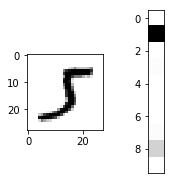

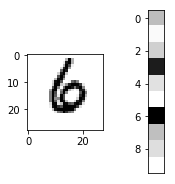

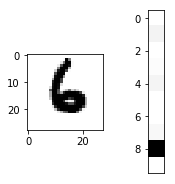

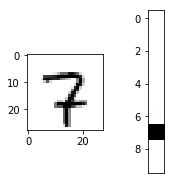

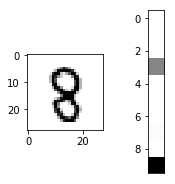

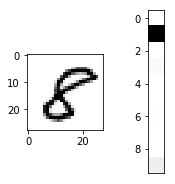

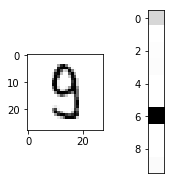

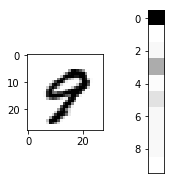

In [44]:
#def draw_output(x)

#IDX = [100,200, 400, 500, 600, 650, 700, 701, 702, 900, 1000, 1100, 1200, 1300]

IDX = range(1,len(features_test),315)

for idx in IDX: 
    #x = features_test[idx]
    x = features[idx]
    #x = features[idx]
    plt.figure(figsize=(3,3))
    #x[x>0] = 1
    plt.subplot(1,2,1)
    plt.imshow(x.reshape(28,28), cmap='gray_r')
    f = mlp_fun(torch.DoubleTensor(x.reshape(28*28,1)), Weight, Bias, Func)
    plt.subplot(1,2,2)
    plt.imshow(f.data, cmap='gray_r')
    plt.xticks([])
    #print(f)
    plt.show()


In [235]:
sm = torch.nn.Softmax(dim=0)
inp = Variable(torch.randn(2, 3))
print(inp)
print(sm(inp))

Variable containing:
 1.7225  1.3250  0.7938
-0.6385  1.7780 -0.1159
[torch.FloatTensor of size 2x3]

Variable containing:
 0.9138  0.3886  0.7129
 0.0862  0.6114  0.2871
[torch.FloatTensor of size 2x3]



# Cross Entropy Loss 

Target class labels $y$ in $[0, C-1]$


In [238]:
# Number of data points 
N = 4
# Number of data points
C = 3

CEloss = torch.nn.CrossEntropyLoss(reduce=True, size_average=False)
#X = np.array([[1,-1,-1],[2,1,0],[-1,3,-2],[1,2,3]])
X = np.random.randn(N, C)

x = torch.DoubleTensor(X)
print(x)
y = torch.LongTensor(N).random_(C)
print(y)



-0.0144  1.7189 -0.1805
 0.1935 -0.9968  0.8177
-0.1434 -0.6371  0.4233
-1.2651  1.1258 -1.2078
[torch.DoubleTensor of size 4x3]


 0
 0
 0
 2
[torch.LongTensor of size 4]



In [239]:
inp = Variable(x, requires_grad=True)
target = Variable(y)
out = CEloss(inp, target)
out

Variable containing:
 6.8918
[torch.DoubleTensor of size 1]

In [240]:
xx = x.numpy()
t = y.numpy()
E = 0
for n,i in enumerate(t):
    E += -xx[n,i] + np.log(np.sum(np.exp(xx[n,:])))

E

6.8918203841043004

In [208]:
x.numpy()

array([[ 1., -1., -1.],
       [ 2.,  1.,  0.],
       [-1.,  3., -2.],
       [ 1.,  2.,  3.]])

In [201]:
x


 1 -1 -1
 2  1  0
-1  3 -2
 1  2  3
[torch.DoubleTensor of size 4x3]

In [172]:
A = torch.LongTensor(*[10,3])

In [183]:
A.random_(100)


   44    75    35
   20    73    92
   58    89     1
   71    17    34
    0    66    27
   68     7    63
   84     9     3
   74    52    45
   66    27    57
   16     5    55
[torch.LongTensor of size 10x3]

In [89]:
f = mlp_fun(torch.DoubleTensor(x.reshape(28*28,1)), Weight, Bias, Func)

In [98]:
loss_fn(f, Variable(torch.DoubleTensor([[0]])))

Variable containing:
 0.6451
[torch.DoubleTensor of size 1]

In [96]:
loss_fn(Variable(torch.DoubleTensor([0])),Variable(torch.DoubleTensor([0.2])))

Variable containing:
 5.5262
[torch.DoubleTensor of size 1]

In [83]:
import torch

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 100, 10, 2

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()


 0
[torch.DoubleTensor of size 1]

$$
 \ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right],
$$

In [69]:
mlp_fun(torch.DoubleTensor(x.reshape(28*28,1)), Weight, Bias, Func)

Variable containing:
1.00000e-02 *
  9.0495
[torch.DoubleTensor of size 1x1]

In [27]:
# Softmax

import numpy as np

x = np.random.randn(2)

[ 0.12539562 -2.65632588]
[ 0.94168006  0.05831994]


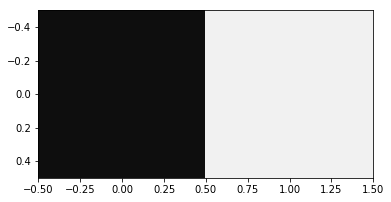

In [28]:
#x = np.array([-1, -1, 1])

sm = np.exp(x)
sm = sm/np.sum(sm)

print(x)
print(sm)

plt.imshow(sm.reshape(1,len(sm)), cmap='gray_r', vmin=0, vmax=1)
plt.show()